<a href="https://colab.research.google.com/github/SabastianGu/ML_prediction_analysis_practice/blob/main/tf_CCN_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget https://archive.org/download/fer2013_202311/fer2013.csv

--2024-09-16 12:02:11--  https://archive.org/download/fer2013_202311/fer2013.csv
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia600507.us.archive.org/35/items/fer2013_202311/fer2013.csv [following]
--2024-09-16 12:02:12--  https://ia600507.us.archive.org/35/items/fer2013_202311/fer2013.csv
Resolving ia600507.us.archive.org (ia600507.us.archive.org)... 207.241.227.187
Connecting to ia600507.us.archive.org (ia600507.us.archive.org)|207.241.227.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301072766 (287M) [text/csv]
Saving to: ‘fer2013.csv’

fer2013.csv         100%[===================>] 287.12M   168MB/s    in 1.7s    

2024-09-16 12:02:13 (168 MB/s) - ‘fer2013.csv’ saved [301072766/301072766]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, Flatten, Activation
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import itertools
from keras import backend as K

image_size = 48

data = pd.read_csv('./fer2013.csv')
data['pixels'] = data['pixels'].apply(lambda x: np.array( x.split(), dtype = 'float32'))
data['pixels'] = data['pixels'].apply(lambda x: x.reshape((image_size, image_size)))
emotions_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data.head()

,emotion,pixels,Usage
0,0,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...",Training
1,0,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11...",Training
2,2,"[[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16...",Training
3,4,"[[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...",Training
4,6,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Training


In [ ]:
def preprocess_data(df, label_column='emotion', pixel_column='pixels', rgb = False):
    # Extract features and labels, and make it colorful if rgm oparameter set to True
    X = np.stack(df[pixel_column].values)
    X = X / 255.0

    if rgb:
        X = np.repeat(X[..., np.newaxis], 3, axis=-1)
    else:
        X = np.expand_dims(X, -1)

    # Convert to TensorFlow tensors
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    y = df[label_column].values
    y = tf.keras.utils.to_categorical(y, num_classes = len(set(data['emotion'].values)))

    return X, y

# Function to split data by 'Usage' and preprocess
def split_and_preprocess(data, usage, label_column='emotion', pixel_column='pixels', rgb = False):
    df = data[data['Usage'] == usage].drop('Usage', axis=1)
    if rgb:
      return preprocess_data(df, label_column, pixel_column, rgb = True)
    else:
      return preprocess_data(df, label_column, pixel_column)



# Preprocess training, validation, and test data
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'confusion_matrix',
                          cmap = plt.cm.Blues):
  """
  This function creates confusion matrix,
  Normalization can be aplied by setting 'normalize = True'
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Non normalized confusion matrix')
  print(cm)
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = "center",
             color = "white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


X_train, y_train = split_and_preprocess(data, 'Training')
X_valid, y_valid = split_and_preprocess(data, 'PublicTest')
X_test, y_test = split_and_preprocess(data, 'PrivateTest')
K = len(set(data['emotion'].values))

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

i = Input(shape = X_train[0].shape)


x = Conv2D(32, (3, 3), activation = 'relu',  kernel_regularizer = tf.keras.regularizers.l2(0.001), padding = 'same')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(K, activation = 'softmax')(x)

model = Model(i, x)
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
r = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), callbacks = [early_stop], epochs = 50)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.2548 - loss: 1.9241 - val_accuracy: 0.3514 - val_loss: 1.6216
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3467 - loss: 1.6148 - val_accuracy: 0.3909 - val_loss: 1.5451
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3809 - loss: 1.5311 - val_accuracy: 0.3848 - val_loss: 1.5853
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4097 - loss: 1.4686 - val_accuracy: 0.4483 - val_loss: 1.4677
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4374 - loss: 1.4211 - val_accuracy: 0.4890 - val_loss: 1.3969
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4556 - loss: 1.3775 - val_accuracy: 0.3784 - val_loss: 1.5922
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4803 - loss: 1.3308 - val_accuracy: 0.4957 - val_loss: 1.3658
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5028 - loss: 1.2948 - val_accuracy:

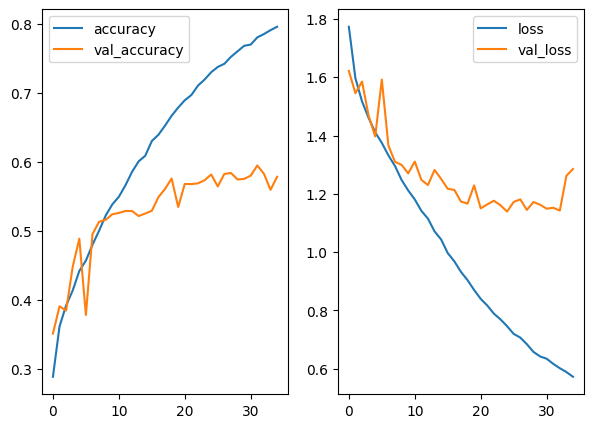

In [ ]:
def plot_acc_loss(r = r):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 5))
    ax1.plot(r.history['accuracy'], label = 'accuracy')
    ax1.plot(r.history['val_accuracy'], label = 'val_accuracy')
    ax1.legend()

    ax2.plot(r.history['loss'], label = 'loss')
    ax2.plot(r.history['val_loss'], label = 'val_loss')
    ax2.legend()

plot_acc_loss(r = r)

In [ ]:
row_count = 6000

class_dfs = [data[data['emotion'] == i] for i in range(7)]
balanced_df = []

for class_df in class_dfs:
  class_count = len(class_df)
  if class_count > row_count:
    class_df_sampled = class_df.sample(n = row_count, random_state = 72)
  else:
    class_df_sampled = resample(class_df, replace = True, n_samples = row_count, random_state = 72)
  balanced_df.append(class_df_sampled)

bal_data = pd.concat(balanced_df)

bal_data = bal_data.sample(frac = 1, random_state = 72).reset_index(drop = True)


X_train_rgb, y_train_rgb = split_and_preprocess(bal_data, 'Training', rgb = True)
train_len = int(len(X_train_rgb))
X_valid_rgb, y_valid_rgb = split_and_preprocess(bal_data, 'PublicTest', rgb = True)
valid_len = int(len(X_valid_rgb))

Epoch 1/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.2178 - loss: 2.0018 - val_accuracy: 0.2397 - val_loss: 1.8195
Epoch 2/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3075 - loss: 1.7151 - val_accuracy: 0.3714 - val_loss: 1.6584
Epoch 3/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3676 - loss: 1.5755 - val_accuracy: 0.3508 - val_loss: 1.6388
Epoch 4/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4229 - loss: 1.4677 - val_accuracy: 0.3901 - val_loss: 1.6379
Epoch 5/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4582 - loss: 1.3788 - val_accuracy: 0.4635 - val_loss: 1.4307
Epoch 6/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4771 - loss: 1.3204 - val_accuracy: 0.4598 - val_loss: 1.5064
Epoch 7/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5149 - loss: 1.2426 - val_accuracy: 0.4689 - val_loss: 1.4459
Epoch 8/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5494 - loss: 1.165

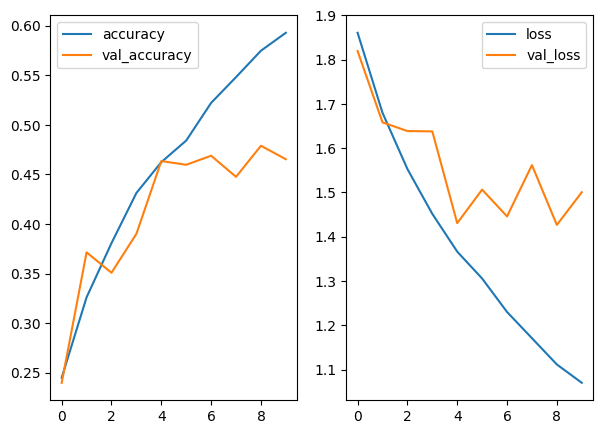

In [ ]:
i = Input(shape = X_train_rgb[0].shape)


x = Conv2D(32, (3, 3), activation = 'relu',  kernel_regularizer = tf.keras.regularizers.l2(0.001), padding = 'same')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(K, activation = 'softmax')(x)

model = Model(i, x)
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

r_rgb = model.fit(X_train_rgb, y_train_rgb, validation_data = (X_valid_rgb, y_valid_rgb), epochs = 50, callbacks = [early_stop])
plot_acc_loss(r_rgb)

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top = False, input_shape = (48, 48, 3), weights = 'imagenet')

def get_vgg16(vgg16, array_input, n_feature_maps):
    vg_input = array_input

    picture_train_features = vgg16.predict(vg_input)
    del (vg_input)

    feature_map = np.empty([n_feature_maps, 512])
    for idx_pic, picture in enumerate(picture_train_features):
        feature_map[idx_pic] = picture
    return feature_map


X_train_vgg = get_vgg16(vgg16, X_train_rgb, train_len)
X_valid_vgg = get_vgg16(vgg16, X_valid_rgb, valid_len)

1048/1048 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3010 - loss: 1.7568 - val_accuracy: 0.3877 - val_loss: 1.6404
Epoch 2/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4408 - loss: 1.4476 - val_accuracy: 0.3807 - val_loss: 1.7201
Epoch 3/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4954 - loss: 1.3151 - val_accuracy: 0.4060 - val_loss: 1.7792
Epoch 4/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5202 - loss: 1.2346 - val_accuracy: 0.4151 - val_loss: 1.8327
Epoch 5/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5461 - loss: 1.1764 - val_accuracy: 0.4205 - val_loss: 1.7810
Epoch 6/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5675 - loss: 1.1230 - val_accuracy: 0.4303 - val_loss: 1.8941
Epoch 7/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5898 - loss: 1.0702 - val_accuracy: 0.4217 - val_loss: 1.9724
Epoch 8/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6113 - loss: 1.0162 -

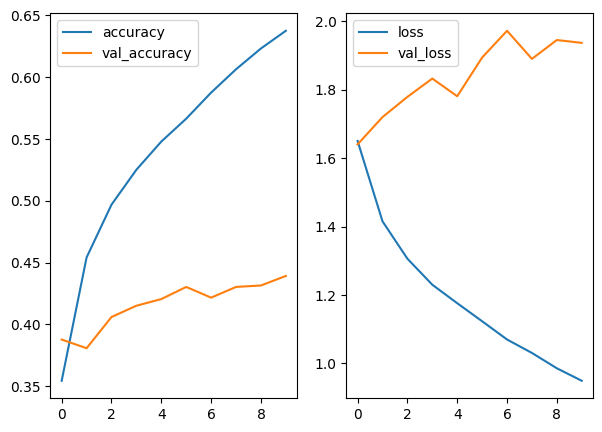

In [ ]:
TopLayer = tf.keras.Sequential()
TopLayer.add(Dense(256, input_shape = (512,), activation = 'relu'))
TopLayer.add(Dense(256, input_shape = (512,), activation = 'relu'))
TopLayer.add(Dropout(0.4))
TopLayer.add(Dense(512, input_shape = (1024,), activation = 'relu'))
TopLayer.add(Dense(7, activation = 'softmax'))

TopLayer.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

T1 = TopLayer.fit(X_train_vgg, y_train_rgb, validation_data = (X_valid_vgg, y_valid_rgb), callbacks = [early_stop], epochs = 50)
plot_acc_loss(T1)

In [ ]:
class_counts = data['emotion'].value_counts()

# Plotting the distribution of classes
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')

# Setting labels and title
plt.title('Distribution of Classes in the Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')

# Display the plot
plt.show()

In [ ]:
row_count = 6000

class_dfs = [data[data['emotion'] == i] for i in range(7)]
balanced_df = []

for class_df in class_dfs:
  class_count = len(class_df)
  if class_count > row_count:
    class_df_sampled = class_df.sample(n = row_count, random_state = 72)
  else:
    class_df_sampled = resample(class_df, replace = True, n_samples = row_count, random_state = 72)
  balanced_df.append(class_df_sampled)

bal_data = pd.concat(balanced_df)

bal_data = bal_data.sample(frac = 1, random_state = 72).reset_index(drop = True)


X_balanced, y_balanced = split_and_preprocess(bal_data, 'Training', rgb = True)
X_val_balance, y_val_balance = split_and_preprocess(bal_data, 'PublicTest', rgb = True)

r_bal = model.fit(X_balanced, y_balanced, validation_data = (X_val_balance, y_val_balance), epochs = 50)
plot_acc_loss(r_bal)

Epoch 1/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3458 - loss: 1.6239 - val_accuracy: 0.3489 - val_loss: 1.7287
Epoch 2/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4032 - loss: 1.4961 - val_accuracy: 0.4553 - val_loss: 1.4911
Epoch 3/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4334 - loss: 1.4179 - val_accuracy: 0.3873 - val_loss: 1.6340
Epoch 4/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4660 - loss: 1.3481 - val_accuracy: 0.4804 - val_loss: 1.4448
Epoch 5/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5014 - loss: 1.2637 - val_accuracy: 0.4341 - val_loss: 1.5837
Epoch 6/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5126 - loss: 1.2310 - val_accuracy: 0.4684 - val_loss: 1.4763
Epoch 7/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5388 - loss: 1.1763 - val_accuracy: 0.3884 - val_loss: 1.6947
Epoch 8/50
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5586 - loss: 1.1413

NameError: name 'plt_acc_loss' is not defined

In [ ]:
#Data Augmentation???